In [83]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import random
from sklearn.metrics import f1_score

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [85]:
# Prepare the dataset
df_text = pd.read_csv('/Users/alex/Desktop/DSAN5000/dsan-5000-project-Ale045/data/01-modified-data/genius_lyrics_cleaned.csv')
df_track = pd.read_csv('/Users/alex/Desktop/DSAN5000/dsan-5000-project-Ale045/data/01-modified-data/top50MusicFrom2010-2019_cleaned.csv')

In [86]:
# Merge the dataset
df = pd.merge(df_text, df_track, left_on=['track_name','artist_name'], right_on=['title', 'artist'], how='inner')

In [87]:
df = df.dropna()

In [88]:
df.head()

,track_name,artist_name,aa,aaliyah,aap,aaron,able,aboutyou,absolutely,abstract,...,beat_y,energy_y,danceability,loudness,valence,duration,acousticness,speechiness,popularity,year_group
0,"Hey, Soul Sister",Train,0,0,0,0,0,0,0,0,...,97,89,67,-4,80,217,19,4,83,2010-2014
1,Love The Way You Lie,Eminem,0,0,0,0,0,0,0,0,...,87,93,75,-5,64,263,24,23,82,2010-2014
2,Bad Romance,Lady Gaga,0,0,0,0,0,0,0,0,...,119,92,70,-4,71,295,0,4,79,2010-2014
3,Just the Way You Are,Bruno Mars,0,0,0,0,0,0,0,0,...,109,84,64,-5,43,221,2,4,78,2010-2014
4,Just the Way You Are,Bruno Mars,0,0,0,0,0,0,0,0,...,109,84,64,-5,43,221,2,4,78,2010-2014


In [89]:
min(df['valence'])

0

In [90]:
df['valence_cat'] = df['valence'].apply(lambda x: 1 if x > 50 else 0)

In [91]:
df['valence_cat'].value_counts() 

valence_cat
1    306
0    275
Name: count, dtype: int64

In [92]:
df['year_group'].value_counts()

year_group
2010-2014    347
2015-2019    234
Name: count, dtype: int64

In [93]:
prior_0 = df['year_group'].value_counts()[0]/len(df)
prior_1 = df['year_group'].value_counts()[1]/len(df)

In [94]:
# leave only the columns we need
df = df.drop(['danceability', 'energy_x', 'energy_y', 'loudness', 'speechiness',
       'acousticness', 'beat_y','artist_name', 'title', 'artist_y', 'genre', 'year_y', 'title', 'track_name', 'year_group'], axis=1)

In [95]:
x = df.drop(['valence_cat'], axis=1)

In [96]:
y = df['valence_cat']

In [97]:
import random
N= x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:] # last 20% of shuffled list

print(train_index[0:10])
print(test_index[0:10])

[176, 571, 13, 329, 314, 337, 72, 139, 251, 415]
[287, 289, 291, 577, 470, 103, 401, 345, 484, 142]


In [98]:
x.columns = range(x.columns.size)
print(x.head())
print(x.sum(axis=0))
x=x.to_numpy()
y = y.values

   0     1     2     3     4     5     6     7     8     9     ...  5251  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   5252  5253  5254  5255  5256  5257  5258  5259  5260  
0     0     0     0     0     0     0    80   217    83  
1     0     0     0     0     0     0    64   263    82  
2     0     0     0     0     0     0    71   295    79  
3     0     0     0     0     0     0    43   221    78  
4     0     0     0     0     0     0    43   221    78  

[5 rows x 5261 columns]
0           36
1            5
2           90
3           13
4            7
         ...  
5256         3
5257        10
5258     30244
5259    130615
5260     38386
Lengt

In [99]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # class_prior=[prior_0,prior_1]
    # INITIALIZE MODEL 
    model = MultinomialNB()


    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start
    f1 = f1_score(y_test, yp_test)

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval, f1)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(y))
print(x.shape,y.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,y,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(581, 5261) (581,)
(581, 5261) (581,)
96.33620689655173 79.48717948717949 0.006460999999999828 0.014299000000001172 0.8032786885245902


In [100]:
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]

In [101]:
# INITIALIZE ARRAYS
initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)

        if(i%5==0):
            print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index=1000)

# SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
partial_grid_search(num_runs=20, min_index=1000, max_index=5500)

5 50 50 58.83620689655172 46.15384615384615
10 100 100 60.991379310344826 47.008547008547005
15 150 150 64.00862068965517 47.008547008547005
20 200 200 65.94827586206897 47.863247863247864
25 250 250 67.24137931034483 47.863247863247864
30 300 300 72.41379310344827 56.41025641025641
35 350 350 73.27586206896551 52.991452991452995
40 400 400 75.86206896551724 57.26495726495726
45 450 450 77.58620689655173 55.55555555555556
50 500 500 78.23275862068965 55.55555555555556
55 550 550 80.60344827586206 58.97435897435898
60 600 600 81.03448275862068 57.26495726495726
65 650 650 82.32758620689656 62.39316239316239
70 700 700 82.11206896551724 60.68376068376068
75 750 750 81.89655172413794 61.53846153846154
80 800 800 81.46551724137932 60.68376068376068
85 850 850 82.11206896551724 58.97435897435898
90 900 900 81.46551724137932 60.68376068376068
95 950 950 81.46551724137932 60.68376068376068
100 1000 1000 82.11206896551724 59.82905982905983
5 2125 2125 86.63793103448276 66.66666666666666
10 325

In [102]:
#UTILITY FUNCTION TO PLOT RESULTS
def plot_results(path_root):

    #PLOT-1
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (red) and Test (blue)')
    plt.savefig(path_root+'-1.png')
    plt.show()

    # #PLOT-2
    plt.plot(num_features,train_time,'-or')
    plt.plot(num_features,eval_time,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
    plt.savefig(path_root+'-2.png')
    plt.show()

    # #PLOT-3
    plt.plot(np.array(test_accuracies),train_time,'-or')
    plt.plot(np.array(test_accuracies),eval_time,'-ob')
    plt.xlabel('test_accuracies')
    plt.ylabel('Runtime: training time (red) and evaluation time (blue)')
    plt.savefig(path_root+'-3.png')
    plt.show()

    # #PLOT-3
    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.savefig(path_root+'-4.png')
    plt.show()

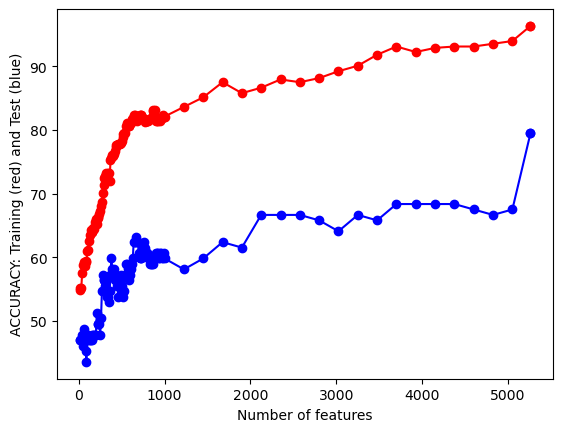

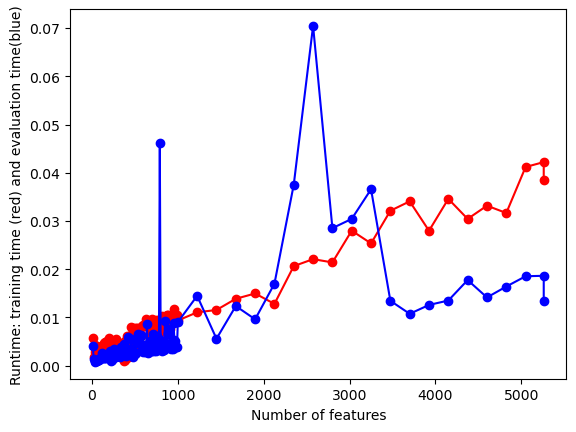

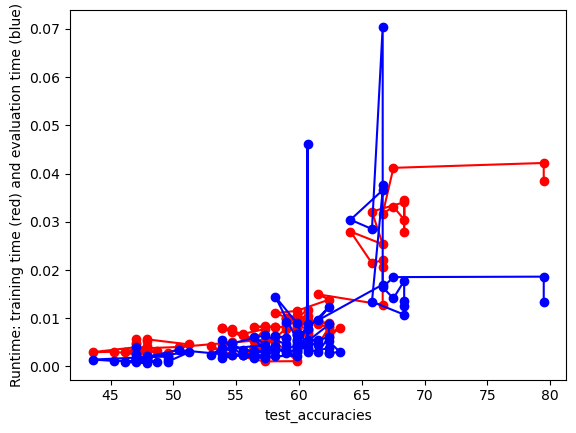

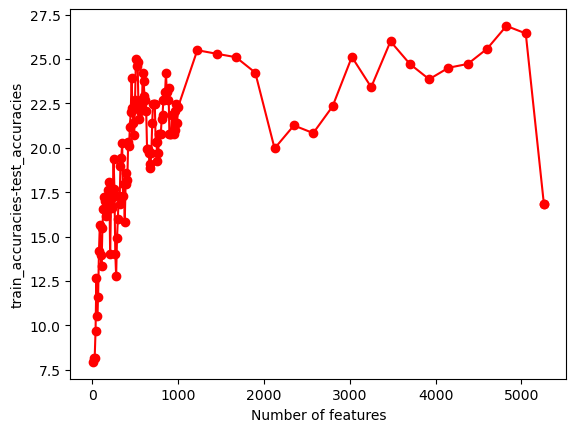

In [103]:
plot_results('results')

In [104]:
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

0.005136849339823024
1152.3875625442513


In [105]:
np.argmax(x_var)

5259

In [106]:
from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

#DOESN"T WORK WELL WITH EDGE VALUES 
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
initialize_arrays()

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)
    print("THRESHOLD =",THRESHOLD, xtmp.shape[1])

    (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)

THRESHOLD = 39.74246187330228 12
THRESHOLD = 79.47978689726474 9
THRESHOLD = 119.21711192122721 6
THRESHOLD = 158.95443694518968 5
THRESHOLD = 198.69176196915214 5
THRESHOLD = 238.42908699311462 4
THRESHOLD = 278.16641201707705 4
THRESHOLD = 317.9037370410395 4
THRESHOLD = 357.64106206500196 2
THRESHOLD = 397.3783870889644 2
THRESHOLD = 437.1157121129269 2
THRESHOLD = 476.8530371368894 2
THRESHOLD = 516.5903621608518 1
THRESHOLD = 556.3276871848143 1
THRESHOLD = 596.0650122087767 1
THRESHOLD = 635.8023372327392 1
THRESHOLD = 675.5396622567017 1
THRESHOLD = 715.2769872806641 1
THRESHOLD = 755.0143123046266 1
THRESHOLD = 794.751637328589 1
THRESHOLD = 834.4889623525515 1
THRESHOLD = 874.2262873765139 1
THRESHOLD = 913.9636124004764 1
THRESHOLD = 953.700937424439 1
THRESHOLD = 993.4382624484014 1
THRESHOLD = 1033.1755874723638 1
THRESHOLD = 1072.9129124963263 1


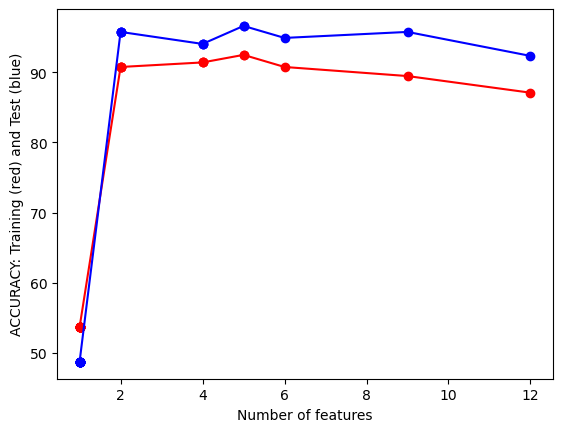

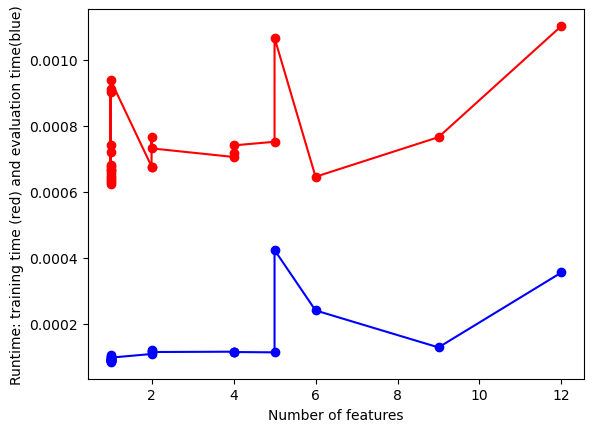

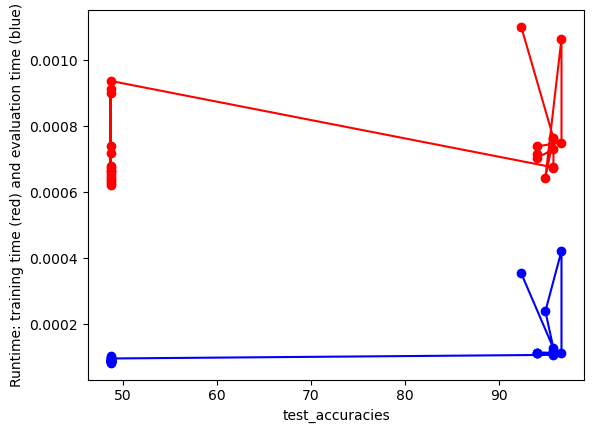

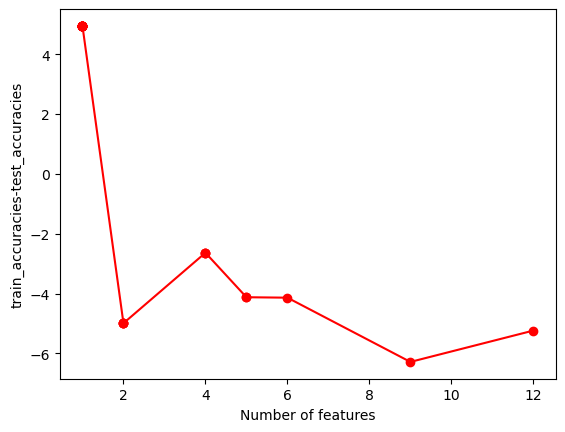

In [107]:
plot_results('results')